In [1]:
import torch
import numpy as np
import scipy
import matplotlib.pyplot as plt

本文主要参考deeplearning的教程

http://deeplearning.net/tutorial/rbm.html

与三个pytorch实现

https://github.com/odie2630463/Restricted-Boltzmann-Machines-in-pytorch

https://github.com/GabrielBianconi/pytorch-rbm

https://github.com/wiseodd/generative-models



受限玻尔兹曼机（RBM）是马尔科夫随机场（MRF）的一种情况，马尔科夫随机场是能量函数模型（EBM）的一种情况。

## 能量函数模型（EBM）

能量函数模型就是用能量函数定义联合概率，与用所谓非标准化概率或权重来定义联合概率其实没什么区别，不过这里能量越高，“权重”越低。一般有

$$
p(x) = \frac{e^{-E(x)}}{Z}
$$

其中$Z$即人见人恶的标准化常数

$$
Z = \sum_x e^{-E(x)}
$$

设$\theta$为能量函数的参数，则$E(x) = E(x,\theta)$，即可利用极大似然法求解参数$\theta$

将$x$分解为可见变量$v$与隐变量$h$是有用的，经常求$v$的边缘概率

$$
p(v) = \sum_h p(v,h) = \sum_h \frac{e^{-E(v,u)}}{Z}
$$

可以定义所谓的自由能$F(v)$来沿用类似前面$E$的记号，有

$$
\begin{align}
p(v) &= \frac{1}{Z} \sum_h e^{-E(v,h)} \\
    &= \frac{1}{Z} \exp \left( \log \left(\sum_h e^{-E(v,h)} \right) \right) \\
    &= \frac{1}{Z} \exp \left( -\left(-\log \left(\sum_h e^{-E(v,h)} \right)\right) \right) \\
    &= \frac{1}{Z} \exp( -\mathcal{F}(v) ) = \frac{e^{-\mathcal{F}(v)}}{Z}
\end{align}
$$

其中$\mathcal{F}(v) = -\log \sum_h e^{-E(v,h)}$即自由能，类似于将给定$v$对应的所有$h$的情况加掉的处理，不过是以能量函数的语言来描述的，既然追求这个特定语言，某些处理自然就显得蹩脚了。另外这里出现了经典的`logsumexp`形式。

另外$Z$也可以表示为自由能形式

$$
Z = \sum_{v,h} e^{-E(v,h)} = \sum_v \sum_h e^{-E(v,h)} = \sum_v \exp(-( -\log \sum_h e^{-E(v,h)})) = \sum_v e^{-\mathcal{F}(v)}
$$

显然，自由能$\mathcal{F}(v)$隐藏了某些计算的细节，如果我们解析地算出了$\mathcal{F}(v)$通过$E(v,h)$的积分或求和，那么利用极大似然法优化
$\mathcal{F}(v)$里的参数和直接优化没有隐变量，从而自由能和能量等价的模型的$E(v,h)$并没有什么区别。然而复杂的求和或积分本身并没有被overcome，
更糟的是还有个$Z$虎视眈眈。

让我们求求它的对数似然的参数导数看看

$$
\begin{align}
\frac{\partial}{\partial \theta} \log p(v) 
&= \frac{\partial}{\partial \theta} \log \frac{e^{-\mathcal{F}(v)}}{Z} \\
&= \frac{\partial}{\partial \theta} -\mathcal{F}(v) - \log Z \\
&= -\frac{\partial \mathcal{F}(v)}{\partial \theta} - \frac{1}{Z} \frac{\partial Z}{\partial \theta} \\
&= -\frac{\partial \mathcal{F}(v)}{\partial \theta} - \frac{1}{Z} \frac{\partial}{\partial \theta}(\sum_v e^{-\mathcal{F}(v)}) \\
&= -\frac{\partial \mathcal{F}(v)}{\partial \theta} + \frac{1}{Z}( \sum_v  e^{-\mathcal{F}(v)} \frac{\partial \mathcal{F}(v)}{\partial \theta}) \\
&= -\frac{\partial \mathcal{F}(v)}{\partial \theta} + ( \sum_v  \frac{e^{-\mathcal{F}(v)}}{Z} \frac{\partial \mathcal{F}(v)}{\partial \theta}) \\
&= -\frac{\partial \mathcal{F}(v)}{\partial \theta} + ( \sum_v  p(v) \frac{\partial \mathcal{F}(v)}{\partial \theta})
\end{align}
$$

注意这是对一个观测的对数似然度，总对数似然要把这些项加起来，这里就不徒增复杂度了。另外这里左边那个$\frac{\partial \mathcal{F}(v)}{\partial \theta}$的$v$时候是函数参数的，右边那个是求和符号给定了，把那个参数屏蔽了。

使用$e^{-E(\cdot)}$这种方式导出概率的一个好处就是这么求导以后那个难以handle的求和可以凑出一个类似期望的形式，这给利用蒙特卡洛积分解
那个求和或积分带来可能。

> 一般来说，对于十分复杂的积分$\int_{X \in S} f(X)$，我们可以设法把这个积分转化成某种随机变量函数的期望，如$\int_{Y \in S'} p(Y) g(Y)$
 如此就可以通过抽取若干$Y$的样本加以平均来近似这个积分。而$Y$的样本抽取可能可以以MCMC之类的方法绕过积分的实质困难。这就是蒙特卡洛积分法
 
观察我们想要进行采样的分布$p(v)$，我们注意到虽然利用MCMC的比例式采样可以绕过$Z$的计算，却不能绕过自由能本身的计算，而自由能计算涉及一个复杂的求和，能量函数本身虽然易于计算，但却涉及未知的隐变量。

不过考虑隐变量的MCMC其实可以求解这个问题，给出一个初试状态（各$v,h$赋值）后使用proposal分布不断采样下一个点，可以采出联合样本，
然后我们只需简单的抛弃隐变量的部分就可以当做我们从$v$边缘分布中采出一个$v$样本。这正是采样法的暴力之处所在。

如果$v,h$是连续的，我们还可以考虑变分推断，对$v,h$各自指定近似分布族，然后以KL散度优化至找出近似分布族中最近似原分布的，然后从
简单得多（如多元正态分布）的近似分布中采样出$v,h$再抛弃掉$h$或直接采样$v$（在我们可以控制的近似分布中要简单得多，比如直接假定$v,h$独立）
都可以考虑。

除了上面的MH采样，也可以考虑Gibbs采样，Gibbs采样要求$p(x_i \mid x_{-i})$，这个分布（的参数）应当较容易求出来且易于采样。这往往要求
模型设定本身使得这个东西容易实现。

## 马尔科夫随机场（MRF）

我们应当注意，马尔科夫随机场的设定使得计算$p(x_i \mid x_{-i})$可能变得相当简单。马尔科夫随机场假定场中的随机变量的分布完全由它的邻域
决定（就像马尔科夫链完全由上一时间的状态决定一样，这就是Markov这个词在MRF中的来历）。所以：

$$
p(x_i \mid x_{-i}) = p(x_i \mid \mathrm{nei}(x_i))
$$

马尔科夫随机场通常用所谓的势函数（potentials function，potential即电动势那个“势”）给图上的最大团的点赋予权重（potential与概率成正比而不是像能量一样成反比），将联合概率分解为

$$
p(x_1,\dots,x_n) = \frac{1}{Z}\phi(x_1,x_2,x_3) \phi(x_2,x_3) \dots, \phi(x_{n-4},\dots,x_n)
$$

这个设定的一个妙处在于拥有条件独立性，通过调整积分符号代出常量等变换容易证明：

$$
p(x_i \mid x_{-i}) = p(x_i \mid N(x_i))
$$

其中$x_{-i}$为除了$x_i$以外的变量，$N(x_i)$为$x_i$的在图上相邻变量，即存在势函数$\phi_i$使得两个变量同时作为它的参数。即获得马尔科夫性。

类似证明上述性质的过程还可以证明可用于Gibbs采样的条件分布

$$
\begin{align}
p(x_i \mid x_{-i}) &= \frac{p(x_1,\dots,x_n)}{\int_{x_i} p(x_1,\dots,x_n)} \\
             &= \frac{\prod \phi(x_i,\dots) \prod \phi(\dots)}{\int_{x_i} \prod \phi(x_i,\dots) \prod \phi(\dots)} \\
             &= \frac{\prod \phi(x_i,\dots) }{\int_{x_i} \prod \phi(x_i,\dots) }
\end{align}
$$

上面的推导中将$\phi$乘积分解为包含$x_i$的和不包含的，并把不包含的移出来消掉了。如果$x_i$的取值是离散的，我们就没必要求分母，只需求出
和$x_i$相关的$\phi$的积（也需要用上当前固定的其他相邻随机变量的值），然后求出概率采样即可。比如后面的二值玻尔兹曼机。如果$x_i$又连续
$\phi$又复杂(也许只有正好凑成正态分布密度函数之类的才能算“不复杂”），则这个方法采样一次可能内部又要基于一次HM算法（如提议一个值比较双方的分子的值决定是否接受，迭代若干次），可能就不如直接
HM有效了，当然这样做因为HM一次改变的值较小，带来的接受率过低的风险就小了。

## 受限玻尔兹曼机（RBM）

从马尔科夫随机场的角度看，受限玻尔兹曼机是二分图（图中的点可以分为两个集合，集合内部没有连接，且与另一个集合中的全部点连接）结构，并把
能量函数（尽管马尔科夫随机场更喜欢用分立的势函数）定义为：

$$
E(v,h) = -b'v -c'h - h'Wv
$$

当然这么定义出的基于能量函数的模型并没有显示出它的马尔科夫随机场的图的形式和条件独立性。比如从二分图上看，我们期望这么个性质。

$$
\begin{align}
p(v_i \mid v_{-i},h) &= p(v_i \mid h) \\
p(h_i \mid v,h_{-i}) &= p(h_i \mid v)
\end{align}
$$

我们尝试把受限玻尔兹曼机表示成马尔科夫随机场来自动证明上述性质。首先二分图上的最大团显然只有那些跨集合的点对，没有任何大于等于三个点的团。
所以每个边都对应一个我们需要定义的势函数。设定：

$$
\phi(v_i,h_j) = \exp((1/n_v)b_i v_i + (1/n_h)c_j h_j +v_i w_{ij} h_j)
$$

则有

$$
p(v,h) =\frac{1}{Z} \prod_i^{n_v} \prod_j^{n_h} \phi(v_i,h_j)
= \frac{1}{Z} \exp( \sum_i^{n_v} \sum_j^{n_h}  (1/n_v)b_i v_i + (1/n_h)c_j h_j +v_i w_{ij} h_j)
= \frac{1}{Z} \exp( -(-b'v -c'h - h'Wv) ) = \frac{e^{-E(v,h)}}{Z} 
$$

这就此以能量函数定义出的联合概率可表示为一二分图上的马尔科夫随机场，从而自动证明了以上条件独立性。

假定$v_i,h_i$只能取$0,1$的话它们就是简单的伯努利分布，runing gibbs sampling require only exact distribution for then, that's it:

$$
\begin{align}
p(v_i \mid v_{-i},h) &= \frac{p(v,h)}{\sum_{v_i} p(v,h)} \\
               &= \frac{\frac{e^{-E(v,h)}}{Z}}{\sum_{v_i} \frac{e^{-E(v,h)}}{Z}} \\
               &= \frac{e^{-E(v,h)}}{\sum_{v_i} e^{-E(v,h)}} \\
               &= \frac{\exp(b'v +c'h + h'Wv)}{\sum_{v_i} \exp(b'v +c'h + h'Wv)} \\
               &= \frac{\exp(b'v + h'Wv)\exp(c'h)}{\sum_{v_i} \exp(b'v + h'Wv)\exp(c'h)} \\
               &= \frac{\exp(b'v + h'Wv)}{\sum_{v_i} \exp(b'v + h'Wv)} \\
               &= \frac{\exp(\sum_i^{n_v} b_i v_i + \sum_{j=1}^{n_h} \sum_{i=1}^{n_v} h_j W_{ji} v_i )}
             {\sum_{v_i} \exp(\sum_i^{n_v} b_i v_i + \sum_{j=1}^{n_h} \sum_{i=1}^{n_v} h_j W_{ji} v_i )} \\
               &= \frac{\prod_i^{n_v}\exp(b_i v_i) \prod_{j=1}^{n_h} \prod_{i=1}^{n_v} \exp(h_j W_{ji} v_i) }
             {\sum_{v_i} \prod_i^{n_v}\exp(b_i v_i) \prod_{j=1}^{n_h} \prod_{i=1}^{n_v} \exp(h_j W_{ji} v_i)} \\
               &= \frac{\exp(b_i v_i) \prod_{j=1}^{n_h} \exp(h_j W_{ji} v_i)}
             {\sum_{v_i} \exp(b_i v_i) \prod_{j=1}^{n_h} \exp(h_j W_{ji} v_i)} \\
               &= \frac{\exp(b_i v_i + \sum_{j=1}^{n_h} h_j W_{ji} v_i)}
             {\sum_{v_i} \exp(b_i v_i + \sum_{j=1}^{n_h} h_j W_{ji} v_i)}
\end{align}
$$

更明显地，讨论$v_i=1$的情况

$$
p(v_i=1 \mid v_{-i}, h) = \frac{\exp(b_i + \sum_{j=1}^{n_h} h_j W_{ji})}{1 + \exp(b_i + \sum_{j=1}^{n_h} h_j W_{ji})}
  = \frac{1}{1+ \exp(-(b_i v_i + \sum_{j=1}^{n_h} h_j W_{ji}))} = sigm(b_i + \sum_{j=1}^{n_h} h_j W_{ji})
$$

类似地
$$
\begin{align}
p(h_j \mid v,h_{-i}) &= \frac{\exp(b'v +c'h + h'Wv)}{\sum_{h_j} \exp(b'v +c'h + h'Wv)} \\
              &= \frac{ \prod_j^{n_h}\exp(c_j h_j) \prod_{j=1}^{n_h} \prod_{i=1}^{n_v} \exp(h_j W_{ji} v_i) }
            {\sum_{v_i} \prod_j^{n_h}\exp(c_j h_j) \prod_{j=1}^{n_h} \prod_{i=1}^{n_v} \exp(h_j W_{ji} v_i)} \\
              &= \frac{ \exp(c_j h_j + \sum_{i=1}^{n_v} h_j W_{ji} v_i)}
            {\sum_{h_j} \exp(c_j h_j + \sum_{i=1}^{n_v} h_j W_{ji} v_i)} 
\end{align}
$$

$h_i=1$的情况

$$
p(h_j=1 \mid v,h_{-i}) 
= \frac{\exp(c_j + \sum_{i=1}^{n_v} W_{ji} v_i)}{1 + \exp(c_j + \sum_{i=1}^{n_v} W_{ji} v_i)}
= \frac{1}{1+ \exp(-(c_j + \sum_{i=1}^{n_v} W_{ji} v_i))} = sigm(c_j + \sum_{i=1}^{n_v} W_{ji} v_i)
$$

知道这些以后可以用来gibbs采样，从而可以在边缘掉隐变量的似然$p(v)$上优化了吗？不，我们其实还是只能从$p(v)$上采样，自由能本身的求导，甚至
自由能本身和它那个恶心的求和的计算并没有被解决。

$$
\begin{align}
\mathcal{F}(v)  &= -\log \sum_h \exp (-E(v,h)) \\
           &= -\log \sum_h \exp(b'v + c'h + h'Wv) \\
           &= -\log \sum_h \exp(b'v)\exp(\sum_{j=1}^{n_h} c_j h_j + \sum_{j=1}^{n_h} \sum_{i=1}^{n_v} h_j W_{ji} v_i) \\
           &= -b'v - \log \sum_h \exp(\sum_{j=1}^{n_h}h_j(c_j +  W_j v))
\end{align}
$$

看起来是个死胡同

$$
\begin{align}
\mathcal{F}(v)  &= -\log \sum_h \exp (-E(v,h)) \\
           &= -\log \sum_h \exp(b'v + c'h + h'Wv) \\
           &= -\log \sum_h \exp(b'v)\exp(\sum_{j=1}^{n_h} c_j h_j + \sum_{j=1}^{n_h} \sum_{i=1}^{n_v} h_j W_{ji} v_i) \\
           &= -b'v - \log \sum_h \prod_{j=1}^{n_h} \exp( c_j h_j) \prod_{j=1}^{n_h} \prod_{i=1}^{n_v} \exp(  h_j W_{ji} v_i)
\end{align}
$$


这里实际需要一个求和和求积交换（这种交换一般是不合法的，不过这里可以），参考：

https://stats.stackexchange.com/questions/211755/in-the-restricted-boltzmann-machines-free-energy-function-how-can-it-be-simpli

这个形式类似于行列式，只不过不加逆序数调整正负号而是将全部排列加起来，从交换的角度看：

$$
\sum_{h=1,\dots,K} \prod_{j=1}^M f_j(h_j) = \prod_{j=1}^M \sum_{h_j=1,\dots,K} f_j(h_j)
$$

从类似行列式的角度看

$$
\begin{bmatrix}
f_1(1) & f_1(2) & \cdots & f_1(K) \\
f_2(1) & f_2(2) & \cdots & f_2(K) \\
\vdots & \vdots & \ddots & \vdots \\
f_M(1) & f_M(2) & \cdots & f_M(K)
\end{bmatrix}
$$

它相当于从每行里选一个元素乘起来，将所有这样的排列乘起来，这也相当于多元函数$f(h_1,\dots,h_M)$的
一种分解$f(h_1,\dots,h_M)=f_1(h_1)\dots,f_M(h_M)$。这个分解的成立使得这种“所有排列和”有一种简便算法，即每行求和后直接乘起来，
是多项式式化简的一种手段，在高等代数里见过类似的操作，这个操作就等价于上面那个换元，从而这个换元除了凑给取对数用以外，
本来对于计算的化简也是有用的（不过取能量化（指数族化）来构建概率函数倒显然是为了凑这个形式，因为所有排列求和是离散边缘概率化的常用操作）。

下述推导用到上述关系和第一条进路

$$
\begin{align}
\mathcal{F}(v)  &= -b'v - \log \sum_h \exp(\sum_{j=1}^{n_h}h_j(c_j +  W_j v)) \\
           &= -b'v - \log \sum_h \prod_{j=1}^{n_h} \exp( h_j(c_j + W_j v)  ) \\
           &= -b'v - \log \prod_{j=1}^{n_h} \sum_{h_j} \exp( h_j(c_j + W_j v) ) \\
           &= -b'v - \sum_{j=1}^{n_h} \log \sum_{h_j} \exp( h_j(c_j + W_j v) )
\end{align}
$$

把讨论范围限制在二值受限玻尔兹曼机上，即$h_j$只能取值$0,1$则上式可以化简为

$$
\mathcal{F}(v) = -b'v - \sum_{j=1}^{n_h} \log( 1+ \exp(h_j(c_j + W_j v)))
$$

至此训练所需要的分析的东西就准备完全了，我们可以考虑怎么推断了。

首先，如果几个RBM的几个参数都确定了，我们显然可以直接从其中采样，只需给定一个$v,h$一个初始状态后，反复轮转使用gibb采样即可，经过最初
的burn-in阶段后得到的样本都可以作为采样样本。丢弃隐变量部分可以看成对原来的显变量的分布的建模。

如果不丢弃隐变量的话，隐变量可以看成一种对显变量的“编码”，在受限玻尔兹曼机经常用到的图像问题上，经常将像素维数（如mnist数据为
$28 \times 28 = 784$维的灰度（$(0,1)$的连续变量））映射成低的多的维数（在前面提到的两个例子中为100+维）。这个编码可以用来
喂给后续的网络，比如一个逻辑斯克回归，这比直接在$784$维或者PCA得到的数据上logsitic回归往往有效得多。（不过由于首先玻尔兹曼机是
线性的，除了图像这种明显信息冗余的东西，一些复杂的分布可能需要需要比本身维数更高的维数的编码才能正确重建，如后面一个例子中
将二维映射成8维，结果才可以接受。）

从显变量到隐变量可以得到一个概率值（二值设定中，来自上述的条件概率），这个概率值可以用来gibbs采样或直接输出，编码就是输出这个概率
或者经过简单阈值转为0，1值版本。编码可以以从隐变量到显变量的解析分布给出显变量的“重建”版本，在自动编码器中损失被直接定义成
显变量的重建版本和原版本的差异，不过RBM里以相对fancy的方式解决了梯度的来历，它优化的是联合概率的显变量的边缘概率，在一定程度上
它已经包含了那种差异，因为那种差异直接对应着一种使得联合概率或边缘概率会比较低的“不一致性”。

重建可以可视化RBM或者自动编码器的效果，还可以做图像处理那种常见的插值图，只需将两图编码，然后在编码中线性插值，然后观察
插值们的重建版本，我们就可以看到编码器“理解”的图的差异是怎么来的，探索编码器黑箱（虽然RBM是概率化的，但它那个秘制矩阵似乎
并没有让它在脱离黑箱化上起什么助益）的某些局部。

这些推断都是在模型的参数确定下才能得到的，RBM的训练看上去面临要同时优化当前训练样本的编码和模型参数的困境，但由于编码也是由模型参数
确定的（EM算法中的则不然），所以我们可以按上述方法直接优化显变量边缘概率，其同时地隐式的优化隐变量（概率）设定。自由能已经可以
解析计算，唯一的麻烦就是那个要采样才能计算的梯度，RBM的原作者已经展示每次采样一个样本就够了。采样的另一个参数$k$是轮转gibbs
采样的轮数，$p(v)$边缘分布是由模型参数决定的，我们只需要随便给个$v_0$经过一个烧入阶段以后取一个或多个样本即可，一个常见的优化是
将$v_0$取成当前数据，然后仅仅迭代$k$次再取一个样本（Contrastive Divergence (CD-k)，专指这种模式
http://www.cs.toronto.edu/~hinton/absps/cdmiguel.pdf ）。

In [2]:
import torch.utils.data
from torchvision import datasets, transforms
#from torchvision.utils import make_grid , save_image

In [3]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=False,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=batch_size)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=batch_size)


In [4]:
list_train_loader = list(train_loader)

In [5]:
data,target = list_train_loader[0]

In [6]:
target

tensor([ 5,  0,  4,  1,  9,  2,  1,  3,  1,  4,  3,  5,  3,  6,
         1,  7,  2,  8,  6,  9,  4,  0,  9,  1,  1,  2,  4,  3,
         2,  7,  3,  8,  6,  9,  0,  5,  6,  0,  7,  6,  1,  8,
         7,  9,  3,  9,  8,  5,  9,  3,  3,  0,  7,  4,  9,  8,
         0,  9,  4,  1,  4,  4,  6,  0])

In [7]:
len(list_train_loader)

938

In [8]:
data.shape

torch.Size([64, 1, 28, 28])

In [9]:
data[0,:,:,:].reshape((-1,28*28)).sum()

tensor(107.9412)

In [10]:
import torch.nn as nn
import torch.nn.functional as F


In [11]:
class RestrictedBoltzmannMachine(nn.Module):
    def __init__(self,n_v,n_h,k):
        super().__init__()
        #self.W = nn.Parameter(torch.randn(n_h,n_v))
        self.W = nn.Parameter(torch.randn(n_h,n_v)*1e-2)
        self.b = nn.Parameter(torch.zeros(n_v))
        self.c = nn.Parameter(torch.zeros(n_h))
        self.k = k
    def prob_v(self, h):
        return F.sigmoid(F.linear(h, self.W.t(), self.b))
    def prob_h(self, v):
        return F.sigmoid(F.linear(v, self.W, self.c))
    def sample(self, p):
        #return F.relu(torch.sign((p - torch.rand(p.shape))))
        return p.bernoulli()
    def free_energy(self, v):
        left = v.mv(self.b)
        right =  F.linear(v, self.W, self.c).exp().add(1).log().sum(1)
        return (-left-right).mean() # 本来应该是直接求和，但直接求和对不同规模的batch就不等价且无法比较了
    def contrastive_divergence(self, v):
        v_ = v
        for _ in range(self.k):
            h_ = self.sample(self.prob_h(v_))
            v_ = self.sample(self.prob_v(h_))
        return self.free_energy(v) - self.free_energy(v_)
    def forward(self, v):
        # 作为更大的神经网络的一部分时按0.5截断强制划分为0,1后以prob_h编码
        return self.prob_h(F.relu(torch.sign(v - 0.5)))

In [12]:
model = RestrictedBoltzmannMachine(28*28, 200, k=1)
opt = torch.optim.SGD(model.parameters(), lr=0.01)

In [13]:
for epoch in range(5):
    loss_ = []
    for data,target in train_loader:
        #print("fuck")
        data = data.view(-1,784).bernoulli()
        cd = model.contrastive_divergence(data)
        loss_.append(cd.item())
        
        opt.zero_grad()
        cd.backward()
        opt.step()
    print(np.mean(loss_))

-30.915021160264004
-18.526689322010032
-16.771129339742764
-16.152569199421766
-15.595125047891125


In [14]:
from torchvision.utils import make_grid

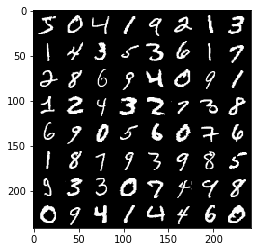

In [15]:
plt.imshow(make_grid(list_train_loader[0][0]).detach().numpy().transpose((1,2,0)))
plt.show()

In [29]:
def cut(x):
    return F.relu(torch.sign(x - 0.5))

def batch_recode():
    data_v = list_train_loader[0][0].view(-1,784)
    data_h = model.prob_h(cut(data_v))
    rebuilt_v = model.prob_v(cut(data_h))
    rebuilt_data = rebuilt_v.view(list_train_loader[0][0].shape)
    return rebuilt_data

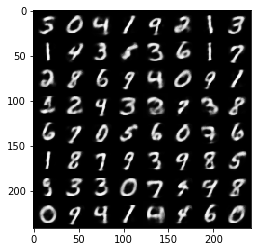

In [19]:
plt.imshow(make_grid(batch_recode()).detach().numpy().transpose((1,2,0)))
plt.show()

In [20]:
opt = torch.optim.SGD(model.parameters(), lr=0.1)

In [21]:
for epoch in range(5):
    loss_ = []
    for data,target in train_loader:
        #print("fuck")
        data = data.view(-1,784).bernoulli()
        cd = model.contrastive_divergence(data)
        loss_.append(cd.item())
        
        opt.zero_grad()
        cd.backward()
        opt.step()
    print(np.mean(loss_))

-10.656002296821903
-8.534473167045284
-7.105806623186384
-5.896970964443963
-4.670960025746685


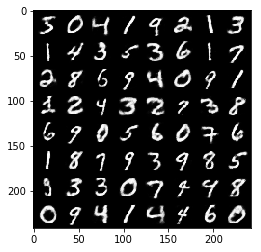

In [30]:
plt.imshow(make_grid(batch_recode()).detach().numpy().transpose((1,2,0)))
plt.show()

我们来从中直接采样，考虑到“有效的”空间可能仅仅是一个这个200维空间的少得多维度的子空间，所以直接给一个随机的隐变量编码
反出来的显变量看起来应该也没什么意义。

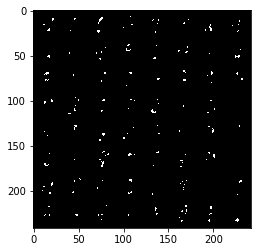

In [33]:
array = cut(model.prob_v(torch.randint(2,(64,200)))).view(list_train_loader[0][0].shape)
plt.imshow(make_grid(array).detach().numpy().transpose((1,2,0)))
plt.show()

In [40]:
h = torch.randint(2,(64,200))
for i in range(10):
    v = model.prob_v(h).bernoulli()
    h = model.prob_h(v).bernoulli()


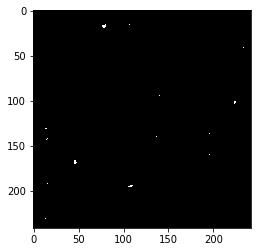

In [41]:
array = v.view(list_train_loader[0][0].shape)
plt.imshow(make_grid(array).detach().numpy().transpose((1,2,0)))
plt.show()

Well... 这就是和GAN的差别我想，你并不能指望能直接从这个所谓的联合分布里采样出什么有用的东西，虽然按理说它应该采出来。

我们再来试试GAN中很流行的图像插值。

In [44]:
prob_h = model.prob_h(list_train_loader[0][0][:2].view(-1,28*28))

In [55]:
prob_h.shape

torch.Size([2, 200])

In [63]:
lw = torch.linspace(0,1.0,64)
lw = torch.stack([lw,1.0-lw],1)
inter_prob_h = lw @ prob_h

In [64]:
inter_prob_h.shape

torch.Size([64, 200])

In [65]:
array = cut(model.prob_v(inter_prob_h)).view(list_train_loader[0][0].shape)

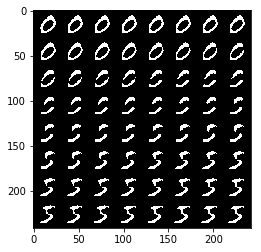

In [66]:
plt.imshow(make_grid(array).detach().numpy().transpose((1,2,0)))
plt.show()

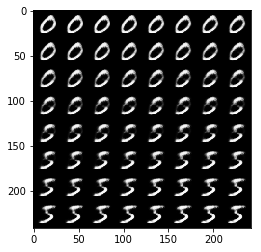

In [70]:
array = model.prob_v(inter_prob_h).view(list_train_loader[0][0].shape)
plt.imshow(make_grid(array).detach().numpy().transpose((1,2,0)))
plt.show()

这个插值看起来不错，有别于以下直接插值结果

In [67]:
inter_prob_v = lw @ list_train_loader[0][0][:2].view(-1,28*28)

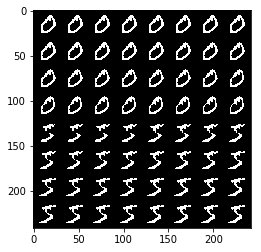

In [69]:
array = cut(inter_prob_v).view(list_train_loader[0][0].shape)
plt.imshow(make_grid(array).detach().numpy().transpose((1,2,0)))
plt.show()

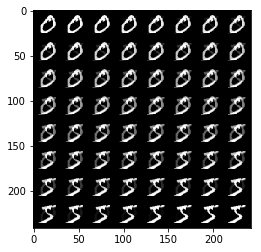

In [71]:
array = inter_prob_v.view(list_train_loader[0][0].shape)
plt.imshow(make_grid(array).detach().numpy().transpose((1,2,0)))
plt.show()

我们再来看看它作为降维编码的效果，比较直接logistic回归与基于它编码的logistic回归的结果

In [85]:
train_feature_flatten = torch.cat([data.view(-1,28*28) for data,label in train_loader])

In [92]:
train_feature_flatten.shape

torch.Size([60000, 784])

In [93]:
train_label = torch.cat([label for data,label in train_loader])

In [94]:
train_label.shape

torch.Size([60000])

In [95]:
train_feature_hidden = model.prob_h(train_feature_flatten) 

In [96]:
train_feature_hidden.shape

torch.Size([60000, 200])

In [72]:
from sklearn.linear_model import LogisticRegression

In [97]:
clf = LogisticRegression()
clf.fit(train_feature_flatten.numpy(),train_label.numpy())
predict = clf.predict(train_feature_flatten)
(predict == train_label.numpy()).mean()

RuntimeError: value cannot be converted to type uint8_t without overflow: 60000

In [101]:
(predict == train_label.numpy()).mean()

0.9279

In [103]:
clf2 = LogisticRegression()
clf2.fit(train_feature_hidden.detach().numpy(),train_label.numpy())
predict2 = clf2.predict(train_feature_hidden.detach().numpy())
(predict2 == train_label.numpy()).mean()

RuntimeError: Can't call numpy() on Variable that requires grad. Use var.detach().numpy() instead.

In [104]:
predict2 = clf2.predict(train_feature_hidden.detach().numpy())
(predict2 == train_label.numpy()).mean()

0.9503833333333334

In [105]:
test_feature_flatten = torch.cat([data.view(-1,28*28) for data,label in test_loader])
test_feature_flatten.shape

torch.Size([10000, 784])

In [109]:
test_feature_hidden = model.prob_h(test_feature_flatten) 
test_feature_hidden.shape

torch.Size([10000, 200])

In [106]:
test_label = torch.cat([label for data,label in test_loader])
test_label.shape

torch.Size([10000])

In [107]:
predict = clf.predict(test_feature_flatten)
(predict == test_label.numpy()).mean()

0.9201

In [110]:
predict2 = clf2.predict(test_feature_hidden.detach().numpy())
(predict2 == test_label.numpy()).mean()

0.9466

data   | train  | test  |
--------|--------|--------|
visied  | 92.79% | 92.01% |
hidden  | 95.03% | 94.66% |

可以看出受限玻尔兹曼机的隐编码明显提高了（最后一层logistic回归）的回归效果。这就是自动编码方面的效果。

--------------